Importing libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

 Load all the datasets and labeling the games with the platforms

In [2]:
df3 = pd.read_csv("AIDataset/genres.csv")
dfs = []
platform_files = [
    ("AIDataset/all_games_Xbox.csv", "Xbox"),
    ("AIDataset/all_games_PlayStation.csv", "PlayStation"),
    ("AIDataset/all_games_PC.csv", "PC"),
    ("AIDataset/all_games_Nintendo.csv", "Nintendo"),
]

for file_path, platform in platform_files:
    try:
        df = pd.read_csv(file_path)
        df["platform"] = platform
        dfs.append(df)
        print(f"Loaded {file_path}: {len(df)} games")
    except FileNotFoundError:
        print(f"File not found: {file_path}")

all_games = pd.concat(dfs, ignore_index=True)
print(f"\nTotal games loaded: {len(all_games)}")

Loaded AIDataset/all_games_Xbox.csv: 14335 games
Loaded AIDataset/all_games_PlayStation.csv: 24040 games
Loaded AIDataset/all_games_PC.csv: 68796 games
Loaded AIDataset/all_games_Nintendo.csv: 22209 games

Total games loaded: 129380


 Remove duplicates

In [3]:
all_games = all_games.drop_duplicates(subset=["name"]).reset_index(drop=True)
print(f"After removing duplicates: {len(all_games)} games\n")

After removing duplicates: 97833 games



Display available columns

In [4]:
all_games.columns = all_games.columns.str.strip().str.lower()
print("AVAILABLE COLUMNS IN DATASET")
print(f"Total columns: {len(all_games.columns)}")
print("\nColumn names:")
for i, col in enumerate(all_games.columns, 1):
    print(f"   {i:2d}. {col}")
# Detect title column
if "name" in all_games.columns:
    title_col = "name"
elif "title" in all_games.columns:
    title_col = "title"
else:
    raise ValueError(" o 'name' or 'title' column found!")


AVAILABLE COLUMNS IN DATASET
Total columns: 14

Column names:
    1. genres
    2. id
    3. name
    4. platforms
    5. summary
    6. storyline
    7. rating
    8. main
    9. extra
   10. completionist
   11. review_score
   12. review_count
   13. people_polled
   14. platform


Detect title column

In [23]:
if "name" in all_games.columns:
    title_col = "name"
elif "title" in all_games.columns:
    title_col = "title"
else:
    raise ValueError("No 'name' or 'title' column found!")

print(f"Using '{title_col}' as game title column")



Using 'name' as game title column


Detect rating column

In [6]:
rating_col = None
rating_candidates = ["rating", "total_rating", "aggregated_rating", "user_rating", "score"]

for col in rating_candidates:
    if col in all_games.columns:
        rating_col = col
        print(f"Found '{rating_col}' column")
        break

if not rating_col:
    print("No rating column found. Using default ratings.")
    all_games["rating"] = 50.0
    rating_col = "rating"

Found 'rating' column


Load and map genres

In [7]:
try:
    genre_map = dict(zip(df3["genre_id"], df3["genre"]))
    
    def map_genres(genre_ids):
        if pd.isna(genre_ids):
            return ""
        genre_ids = str(genre_ids).replace("[","").replace("]","").replace(" ","")
        if genre_ids == "":
            return ""
        return " ".join([genre_map.get(int(g), "") for g in genre_ids.split(",") if g.isdigit()])
    
    if "genres" in all_games.columns:
        all_games["genre_text"] = all_games["genres"].apply(map_genres)
        print("Mapped genre IDs to genre names")
    else:
        all_games["genre_text"] = ""
except (FileNotFoundError, KeyError):
    all_games["genre_text"] = ""
    print("Could not load genres mapping")

Mapped genre IDs to genre names


Build combined text features

In [8]:
text_columns = ["summary", "storyline", "description", "overview", "about"]
combined_parts = []

for col in text_columns:
    if col in all_games.columns:
        combined_parts.append(all_games[col].fillna("").astype(str))
        print(f"Using: {col}")

if "genre_text" in all_games.columns:
    combined_parts.append(all_games["genre_text"].fillna(""))
    print(f"Using: genre_text")

combined_parts.append(all_games["platform"].fillna(""))
print(f"Using: platform")

if combined_parts:
    all_games["combined_features"] = combined_parts[0].astype(str)
    for part in combined_parts[1:]:
        all_games["combined_features"] = all_games["combined_features"] + " " + part.astype(str)
else:
    raise ValueError("No text columns found to build features!")

print(f"Combined features created successfully\n")

Using: summary
Using: storyline
Using: genre_text
Using: platform
Combined features created successfully



TF-IDF vectorization

In [9]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=3000,
    min_df=2
)

tfidf_matrix = tfidf.fit_transform(all_games["combined_features"])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}\n")

TF-IDF matrix shape: (97833, 3000)



Prepare and normalize ratings

In [10]:
all_games["rating_score"] = pd.to_numeric(all_games[rating_col], errors="coerce")
all_games["has_rating"] = all_games["rating_score"].notna().astype(int)

neutral_rating = all_games["rating_score"].mean()
if pd.isna(neutral_rating):
    neutral_rating = 50.0
   
all_games["rating_score"] = all_games["rating_score"].fillna(neutral_rating)

scaler = MinMaxScaler()
all_games["normalized_rating"] = scaler.fit_transform(all_games[["rating_score"]])

Recommendation function

In [11]:
def recommend_games(game_title, platform=None, top_n=10, content_weight=0.6, rating_weight=0.4):
    """
    Get game recommendations using hybrid approach
    """
    # Find the game
    matches = all_games[all_games[title_col].str.lower() == game_title.lower()]
    
    if matches.empty:
        print(f"\nExact match not found for '{game_title}'")
        print("\nSimilar games found:")
        similar = all_games[all_games[title_col].str.lower().str.contains(
            game_title.lower(), na=False
        )]
        if not similar.empty:
            print(similar[[title_col, "platform"]].head(10).to_string(index=False))
        else:
            print("No similar games found.")
        return pd.DataFrame()
    
    ref_index = matches.index[0]
    ref_game = all_games.iloc[ref_index]
    
    print(f"\nFinding recommendations for: {ref_game[title_col]}")
    print(f"   Platform: {ref_game['platform']}")
    print(f"   Rating: {ref_game['rating_score']:.1f}\n")
    
    # Content similarity
    content_sim = linear_kernel(tfidf_matrix[ref_index], tfidf_matrix).flatten()
    
    # Rating scores
    rating_scores = all_games["normalized_rating"].values
    
    # Hybrid score
    hybrid_scores = (
        content_weight * content_sim +
        rating_weight * rating_scores * all_games["has_rating"].values
    )
    
    # Create results
    temp = all_games.copy()
    temp["content_similarity"] = content_sim
    temp["hybrid_score"] = hybrid_scores
    
    # Remove reference game
    temp = temp[temp.index != ref_index]
    
    # Filter by platform if specified
    if platform:
        temp = temp[temp["platform"].str.lower() == platform.lower()]
        print(f"Filtered to {platform} platform: {len(temp)} games\n")
    
    # Sort by hybrid score
    recommendations = temp.sort_values("hybrid_score", ascending=False).head(top_n)
    
    return recommendations[[title_col, "platform", "rating_score", "content_similarity", "hybrid_score"]]



Plot top recommendations bar chart

In [12]:
def plot_top_recommendations_bar(game_title, platform=None, top_n=10):
    """
    Bar chart showing top N recommended games with their hybrid scores
    """
    recommendations = recommend_games(game_title, platform, top_n)
    
    if recommendations.empty:
        print("Cannot generate graph - no recommendations found.")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Truncate long game names
    game_names = [name[:30] + '...' if len(name) > 30 else name 
                  for name in recommendations[title_col]]
    scores = recommendations['hybrid_score'].values
    
    # Create color gradient from blue to green
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(scores)))
    
    bars = plt.barh(range(len(game_names)), scores, color=colors)
    plt.yticks(range(len(game_names)), game_names)
    plt.xlabel('Hybrid Recommendation Score', fontsize=12, fontweight='bold')
    plt.ylabel('Game Title', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Recommendations for: {game_title}', 
              fontsize=14, fontweight='bold')
    
    # Add score labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(score + 0.01, i, f'{score:.3f}', 
                va='center', fontsize=9)
    
    plt.gca().invert_yaxis()  # Highest score on top
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)
    plt.show()





Plot method comparison bar chart

In [13]:
def plot_method_comparison_bar(game_title, platform=None, top_n=10):
    """
    Compare average scores from Content-Based, Hybrid, and Rating-Based methods
    """
    # Get recommendations from all three methods
    content_recs = recommend_games(game_title, platform, top_n, 
                                   content_weight=1.0, rating_weight=0.0)
    hybrid_recs = recommend_games(game_title, platform, top_n,
                                  content_weight=0.6, rating_weight=0.4)
    rating_recs = recommend_games(game_title, platform, top_n,
                                  content_weight=0.3, rating_weight=0.7)
    
    if content_recs.empty or hybrid_recs.empty or rating_recs.empty:
        print("Cannot generate comparison - insufficient recommendations.")
        return
    
    # Calculate average scores
    methods = ['Content-Based\n(100% Content)', 
               'Hybrid\n(60% Content, 40% Rating)', 
               'Rating-Focused\n(30% Content, 70% Rating)']
    
    avg_scores = [
        content_recs['content_similarity'].mean(),
        hybrid_recs['hybrid_score'].mean(),
        rating_recs['hybrid_score'].mean()
    ]
    
    plt.figure(figsize=(10, 6))
    
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    bars = plt.bar(methods, avg_scores, color=colors, edgecolor='black', linewidth=1.5)
    
    plt.ylabel('Average Recommendation Score', fontsize=12, fontweight='bold')
    plt.xlabel('Recommendation Method', fontsize=12, fontweight='bold')
    plt.title(f'Method Comparison for: {game_title}', 
              fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, score in zip(bars, avg_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.ylim(0, max(avg_scores) * 1.15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()





Plot platform distribution pie chart

In [14]:
def plot_platform_distribution_pie(game_title, platform=None, top_n=10):
    """
    Pie chart showing platform distribution of recommended games
    """
    recommendations = recommend_games(game_title, platform, top_n)
    
    if recommendations.empty:
        print("Cannot generate graph - no recommendations found.")
        return
    
    # Count games per platform
    platform_counts = recommendations['platform'].value_counts()
    
    plt.figure(figsize=(10, 8))
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    explode = [0.05] * len(platform_counts)  # Slightly separate slices
    
    wedges, texts, autotexts = plt.pie(
        platform_counts.values,
        labels=platform_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors[:len(platform_counts)],
        explode=explode,
        shadow=True
    )
    
    # Enhance text
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    plt.title(f'Platform Distribution in Top {top_n} Recommendations\nfor: {game_title}', 
              fontsize=14, fontweight='bold')
    
    # Add legend with counts
    legend_labels = [f'{platform}: {count} games' 
                     for platform, count in platform_counts.items()]
    plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()




Plot similarity heatmap

In [15]:
def plot_similarity_heatmap(game_title, platform=None, top_n=10):
    """
    Heatmap showing content similarity between input game and top recommendations
    """
    recommendations = recommend_games(game_title, platform, top_n)
    
    if recommendations.empty:
        print("Cannot generate heatmap - no recommendations found.")
        return
    
    # Find the input game index
    matches = all_games[all_games[title_col].str.lower() == game_title.lower()]
    if matches.empty:
        print(f"Cannot find '{game_title}' for heatmap.")
        return
    
    ref_index = matches.index[0]
    
    # Get indices of recommended games
    rec_indices = recommendations.index.tolist()
    
    # Combine reference game + recommendations
    all_indices = [ref_index] + rec_indices
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix[all_indices])
    
    # Create labels
    game_names = [game_title + " (INPUT)"] + [
        name[:25] + '...' if len(name) > 25 else name 
        for name in recommendations[title_col]
    ]
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',
        xticklabels=game_names,
        yticklabels=game_names,
        cbar_kws={'label': 'Content Similarity Score'},
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title(f'Content Similarity Heatmap\nInput: {game_title}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Games', fontsize=12)
    plt.ylabel('Games', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()




Plot multi-game comparison heatmap

In [16]:
def plot_multi_game_comparison_heatmap(game_titles):
    """
    Compare similarity between multiple games
    
    Parameters:
    -----------
    game_titles : list
        List of game titles to compare (e.g., ['Game1', 'Game2', 'Game3'])
    """
    # Find indices for given games
    indices = []
    valid_titles = []
    
    for title in game_titles:
        matches = all_games[all_games[title_col].str.lower() == title.lower()]
        if not matches.empty:
            indices.append(matches.index[0])
            valid_titles.append(matches.iloc[0][title_col])
        else:
            print(f"'{title}' not found")
    
    if len(indices) < 2:
        print("Need at least 2 valid games for comparison heatmap")
        return
    
    # Calculate similarity matrix for these games
    similarity_matrix = cosine_similarity(tfidf_matrix[indices])
    
    # Truncate long names
    display_names = [name[:30] + '...' if len(name) > 30 else name 
                     for name in valid_titles]
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        xticklabels=display_names,
        yticklabels=display_names,
        cbar_kws={'label': 'Content Similarity Score'},
        linewidths=1,
        linecolor='white',
        vmin=0,
        vmax=1,
        center=0.5
    )
    
    plt.title('Multi-Game Content Similarity Comparison', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Games', fontsize=12)
    plt.ylabel('Games', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\nCompared {len(valid_titles)} games successfully!")

Generate all graphs

In [17]:
def generate_all_graphs(game_title, platform=None, top_n=10):
    """
    Visualizations
    """
    
    print("\n1️ Top Recommendations Bar Chart")
    plot_top_recommendations_bar(game_title, platform, top_n)
    
    print("\n2️ Method Comparison Bar Chart")
    plot_method_comparison_bar(game_title, platform, top_n)
    
    print("\n3️ Platform Distribution Pie Chart")
    plot_platform_distribution_pie(game_title, platform, top_n)
    
    print("\n4️ Similarity Heatmap")
    plot_similarity_heatmap(game_title, platform, top_n)
    

Game recommender

In [25]:
def game_recommender():
    """
    Simple interactive mode with 3 questions 
    """

    print("GAME RECOMMENDATION SYSTEM")

    while True:
        # Question 1: Game name
        game_name = input("\nEnter game name (or 'quit' to exit): ").strip()
        
        if game_name.lower() in ['quit', 'exit', 'q']:
            print("\nThank you for using the recommendation system!")
            break
        
        if not game_name:
            print("Please enter a valid game name.")
            continue
        
        # Question 2: Platform
        print("\nAvailable platforms:")
        print("   1. PC")
        print("   2. PlayStation")
        print("   3. Xbox")
        print("   4. Nintendo")
        print("   5. All platforms")
        
        platform_choice = input("\nSelect platform (1-5): ").strip()
        
        platform_map = {
            '1': 'PC',
            '2': 'PlayStation',
            '3': 'Xbox',
            '4': 'Nintendo',
            '5': None
        }
        
        platform_filter = platform_map.get(platform_choice, None)
        
        # Question 3: Number of recommendations
        while True:
            try:
                num_recs = input("\nHow many recommendations? (default: 10): ").strip()
                top_n = int(num_recs) if num_recs else 10
                if top_n > 0:
                    break
                else:
                    print("Please enter a positive number.")
            except ValueError:
                print("Please enter a valid number.")
        
        # Generate recommendations
        result = recommend_games(game_name, platform_filter, top_n)
        
        if not result.empty:
            print("RECOMMENDATIONS:")
            print("="*80)
            print("\n" + result[[title_col, "platform", "rating_score", "hybrid_score"]].to_string(index=False))
            
            # Automatically generate all visualizations
            generate_all_graphs(game_name, platform_filter, top_n)
        
        # Ask if user wants to continue
        continue_choice = input("\nWould you like another recommendation? (yes/no): ").strip().lower()
        if continue_choice in ['no', 'n']:
            print("\nThank you for using the recommendation system!")
            break

Run the program

GAME RECOMMENDATION SYSTEM



Enter game name (or 'quit' to exit):  Stardew Valley



Available platforms:
   1. PC
   2. PlayStation
   3. Xbox
   4. Nintendo
   5. All platforms



Select platform (1-5):  5

How many recommendations? (default: 10):  7


RECOMMENDATIONS:

                             name    platform  rating_score  hybrid_score
         Disney Dreamlight Valley        Xbox     79.758811      0.505281
Gothic II: The Night of the Raven          PC     90.313707      0.496153
                      Clover Tale          PC     90.000000      0.493843
   Harvest Moon: A Wonderful Life    Nintendo     89.357497      0.492763
Harvest Moon: Hero of Leaf Valley PlayStation     79.797733      0.485998
              Light & Dark Bundle        Xbox     80.000000      0.469663
                 Quest for Infamy        Xbox     70.000000      0.466020

1️ Top Recommendations Bar Chart


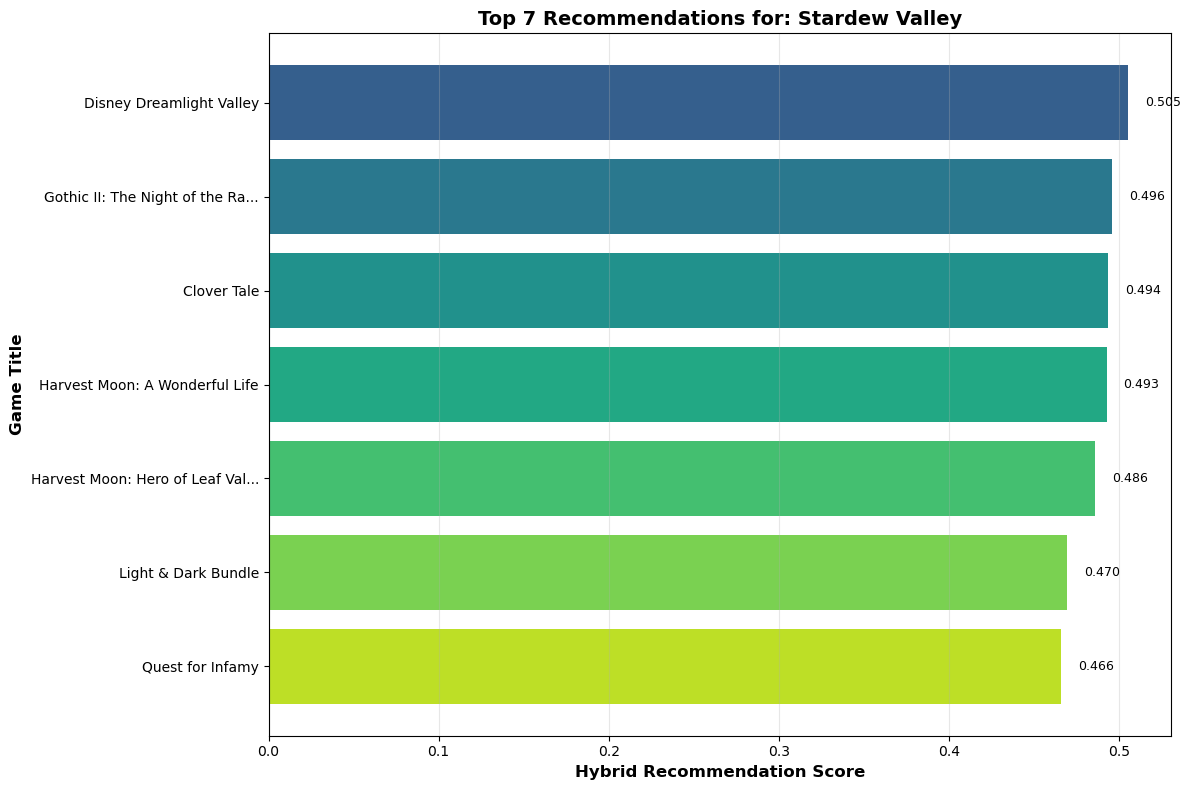


2️ Method Comparison Bar Chart


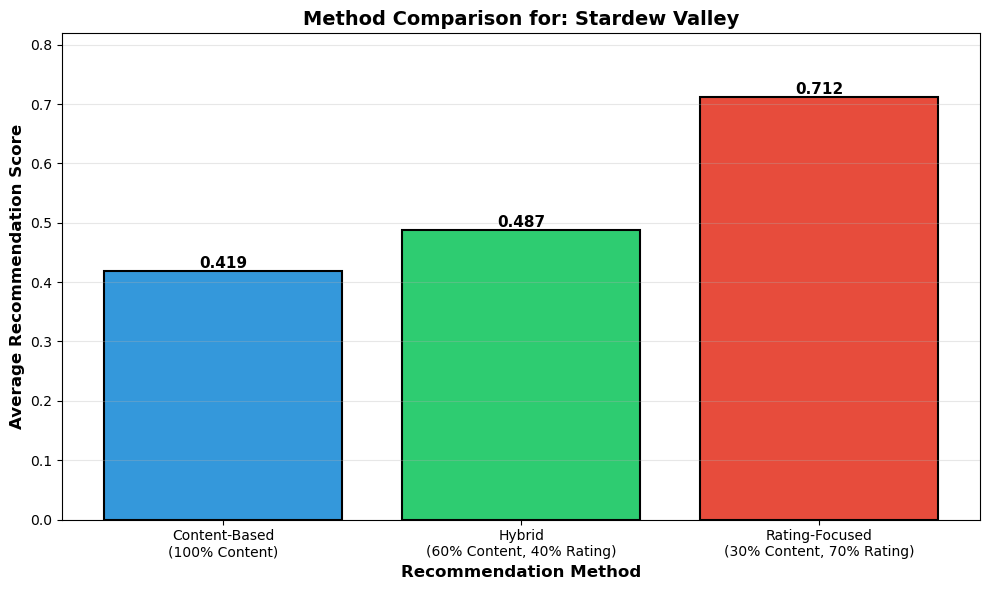


3️ Platform Distribution Pie Chart


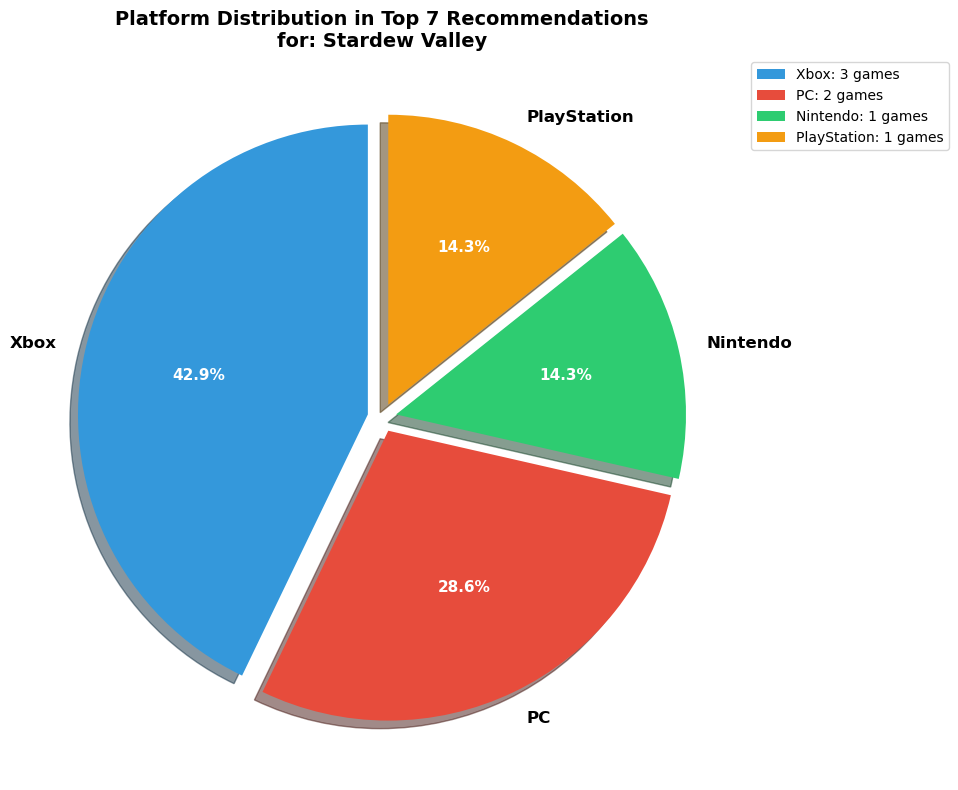


4️ Similarity Heatmap


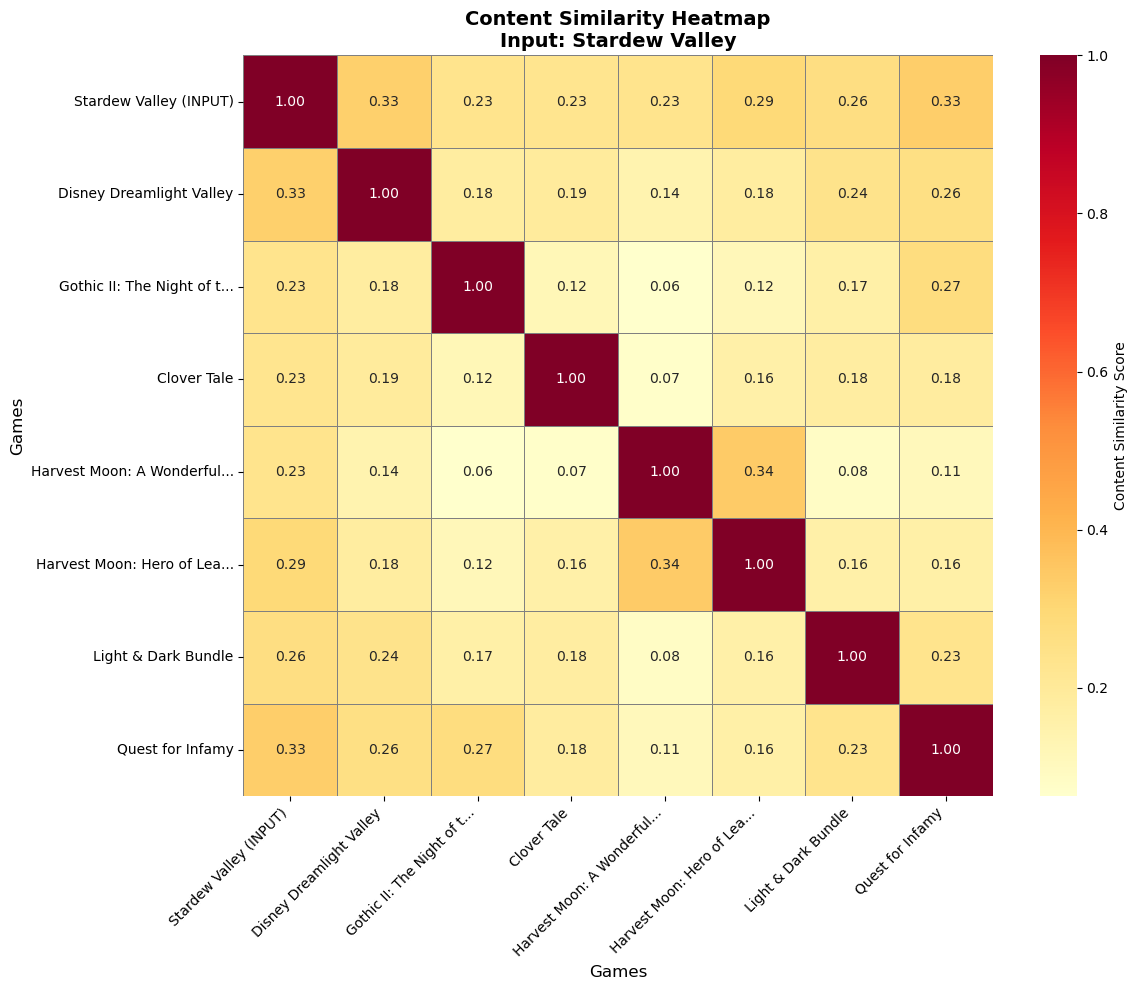


Would you like another recommendation? (yes/no):  np

Enter game name (or 'quit' to exit):  quit



Thank you for using the recommendation system!


In [26]:
if __name__ == "__main__":
    game_recommender()